In [1]:
import numpy as np
from cellpose import (
    core,
    models,
    io
)

from tqdm import trange
from torch.utils.data import (
    ConcatDataset,
    DataLoader
)

import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

io.logger_setup()
assert core.use_gpu() == 1, "No GPU detected"



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	linux 
python version: 	3.12.10 
torch version:  	2.7.1+cu128! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


2025-06-20 09:29:34,388 [INFO] WRITING LOG OUTPUT TO /home/user/.cellpose/run.log
2025-06-20 09:29:34,388 [INFO] 
cellpose version: 	4.0.4 
platform:       	linux 
python version: 	3.12.10 
torch version:  	2.7.1+cu128
2025-06-20 09:29:34,611 [INFO] ** TORCH CUDA version installed and working. **


In [2]:
import os
from typing import Tuple

import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class CellposeDataset(Dataset):
    images: list[np.ndarray]
    masks: list[np.ndarray]
    blend: float
    rng: np.random.Generator
    pdf: callable

    def __init__(self, path: str, blend: float = 1.):
        n_files = len(os.listdir(path))
        assert n_files % 2 == 0

        count = n_files // 2

        print("Loading images")
        self.images = list(map(
            lambda idx: np.array(Image.open("{}/{:03}_img.png".format(
                path, idx
            ))) / 255.,
            range(count)
        ))

        print("Loading masks")
        self.masks = list(map(
            lambda idx: np.array(Image.open("{}/{:03}_masks.png".format(
                path, idx
            ))),
            range(count)
        ))
    
    def getRNG(self) -> np.random.Generator:
        return self.rng

    def __getitem__(self,idx: int) -> Tuple[np.array, np.array]:
        return self.images[idx], self.masks[idx]

    def __len__(self) -> int:
        return len(self.images)


In [3]:
dt = CellposeDataset("./test")

Loading images
Loading masks


In [4]:
model = models.CellposeModel(gpu=True)

2025-06-20 09:29:56,479 [INFO] ** TORCH CUDA version installed and working. **
2025-06-20 09:29:56,480 [INFO] >>>> using GPU (CUDA)


2025-06-20 09:29:58,578 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /home/user/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [01:18<00:00, 15.6MB/s]


In [9]:
def compute_acc_prec(masks: np.array, real_mask: np.array) -> tuple[float, float]:
    masks = np.isin(masks, [0])
    real_mask = np.isin(real_mask, [0])

    tot = masks.shape[0]*masks.shape[1]
    fp_plus_fn = np.count_nonzero(masks ^ real_mask)
    tp = np.count_nonzero(masks & real_mask)
    fp = np.count_nonzero(masks & ~real_mask)

    accuracy = 1 - fp_plus_fn / tot
    precision = tp / (tp + fp)
    avg_precision = tp / (tp + fp_plus_fn)

    return accuracy, precision, avg_precision

def compute_accuracy_and_precision(filter_ = None) -> tuple[float, float]:
	def running_ex(i):
		print(f"{i} / {len(dt)}")
		img, real_mask = dt[i]
		if filter_ is not None:
			img = filter_(img)
		masks, flows, styles = model.eval(img, flow_threshold=0.4, cellprob_threshold=0, normalize={"tile_norm_blocksize": 0})
		
		return compute_acc_prec(masks, real_mask)

	acc_prec = list(map(running_ex, range(len(dt))))

	sum_accuracy = sum(map(
		lambda x: x[0],
		acc_prec
	))
	sum_precision = sum(map(
		lambda x: x[1],
		acc_prec
	))
	sum_avg_precision = sum(map(
		lambda x: x[2],
		acc_prec
	))
	return (sum_accuracy / len(dt)), (sum_precision / len(dt)), (sum_avg_precision / len(dt))


## First results of signal independants noises

In [10]:
output_normal = []
rng = np.random.default_rng()
noise_level = np.arange(0., 0.3+0.01, 0.03)

for noise in noise_level:
	print(f"Testing dataset with noise of {noise}")
	def img_filter(img: np.array) -> np.array:
		out = img + noise * rng.normal(size=img.shape)
		return np.clip(out, 0., 1.)
	
	output_normal.append(compute_accuracy_and_precision(img_filter))
output_normal = np.array(output_normal)

Testing dataset with noise of 0.0
0 / 68
1 / 68
2 / 68
3 / 68
4 / 68
5 / 68
6 / 68
7 / 68
8 / 68
9 / 68
10 / 68
11 / 68
12 / 68


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 5.60 GiB of which 113.25 MiB is free. Process 18314 has 80.00 MiB memory in use. Including non-PyTorch memory, this process has 4.71 GiB memory in use. Of the allocated memory 3.68 GiB is allocated by PyTorch, and 866.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

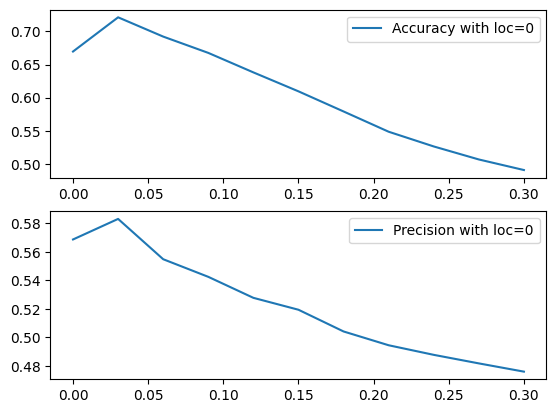

In [ ]:
ax = plt.subplot(2, 1, 1)
ax.plot(noise_level, output_normal[:,0], label=f"Accuracy with loc={0}")
ax.legend()
ax = plt.subplot(2, 1, 2)
ax.plot(noise_level, output_normal[:,1], label=f"Precision with loc={0}")
ax.legend()
plt.show()

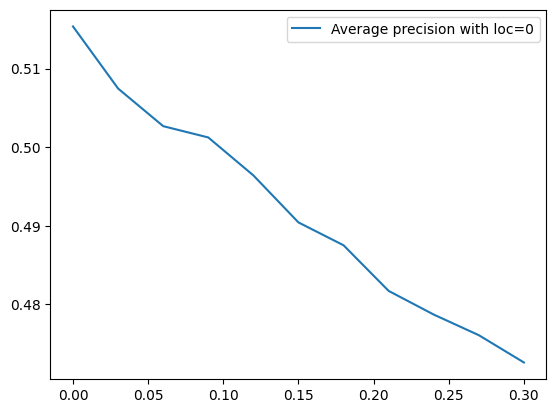

In [ ]:
plt.plot(noise_level, output_normal[:,2], label=f"Average precision with loc={0}")
plt.legend()
plt.show()

In [ ]:
output_poisson = []
lam = 4.

for noise in noise_level:
	print(f"Testing dataset with noise of {noise}")
	def img_filter(img: np.array) -> np.array:
		out = img + noise * rng.poisson(lam=lam, size=img.shape)
		return np.clip(out, 0., 1.)
	
	output_poisson.append(compute_accuracy_and_precision(img_filter))
output_poisson = np.array(output_poisson)

Testing dataset with noise of 0.0
0 / 68
5 / 68
10 / 68
15 / 68
20 / 68
25 / 68
30 / 68
35 / 68
40 / 68
45 / 68
50 / 68
55 / 68
60 / 68
65 / 68
66 / 68
67 / 68


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacity of 5.60 GiB of which 221.12 MiB is free. Process 18314 has 80.00 MiB memory in use. Including non-PyTorch memory, this process has 4.65 GiB memory in use. Of the allocated memory 4.13 GiB is allocated by PyTorch, and 372.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

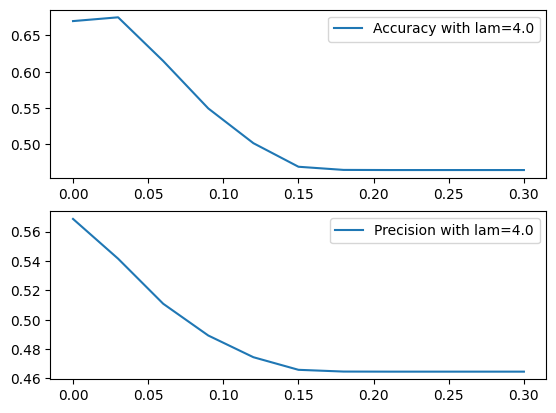

In [ ]:
ax = plt.subplot(2, 1, 1)
ax.plot(noise_level, output_poisson[:,0], label=f"Accuracy with lam={lam}")
ax.legend()
ax = plt.subplot(2, 1, 2)
ax.plot(noise_level, output_poisson[:,1], label=f"Precision with lam={lam}")
ax.legend()
plt.show()

In [11]:
plt.plot(noise_level, output_poisson[:,2], label=f"Average precision with lam={lam}")
plt.legend()
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [13]:
gaussian_std = np.arange(0., 3.01, 1.0)
noise_level = np.arange(0., 0.3+0.01, 0.03)

output_normal_with_filter = []
rng = np.random.default_rng()

for noise in noise_level:
    tmp = []
    for blur_std in gaussian_std:
        print(f"Testing dataset with noise of {noise} & blur {blur_std}")
        def img_filter(img: np.array) -> np.array:
            out = gaussian_filter(img, sigma=blur_std) + noise * rng.normal(size=img.shape)
            return np.clip(out, 0., 1.)
        
        tmp.append(compute_accuracy_and_precision(img_filter))
    output_normal_with_filter.append(tmp)
output_normal_with_filter = np.array(output_normal_with_filter)

Testing dataset with noise of 0.0 & blur 0.0
0 / 68
5 / 68
10 / 68
15 / 68
2025-06-20 09:12:55,045 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing
2025-06-20 09:12:55,059 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing
2025-06-20 09:12:55,066 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing
2025-06-20 09:12:55,077 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing
6 / 68
16 / 68
2025-06-20 09:12:55,620 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing
2025-06-20 09:12:55,620 [WARNING] WARNING: more than 2 channels given, use 'channels' inpu

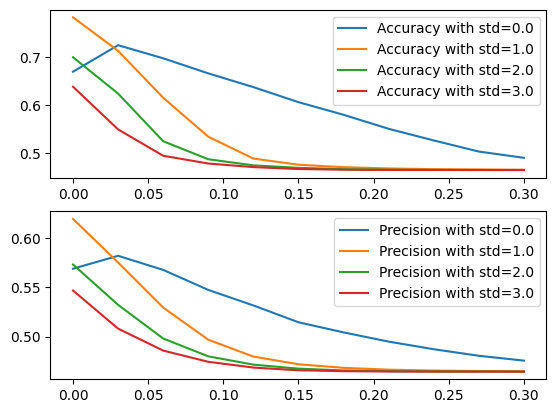

In [15]:
for i, std in enumerate(gaussian_std):
    ax = plt.subplot(2, 1, 1)
    ax.plot(noise_level, output_normal_with_filter[:,i,0], label=f"Accuracy with std={std}")
    ax.legend()
    ax = plt.subplot(2, 1, 2)
    ax.plot(noise_level, output_normal_with_filter[:,i,1], label=f"Precision with std={std}")
    ax.legend()
plt.show()

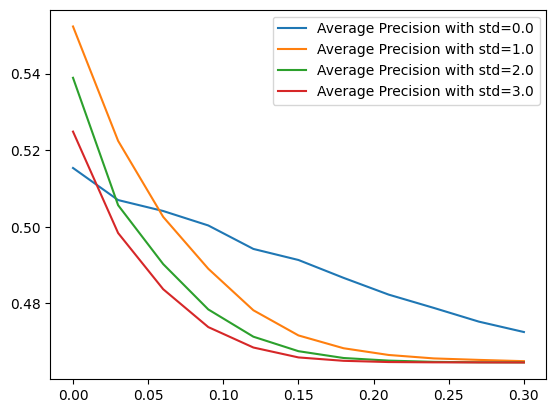

In [14]:
for i, std in enumerate(gaussian_std):
    plt.plot(noise_level, output_normal_with_filter[:,i,2], label=f"Average Precision with std={std}")
    plt.legend()
plt.show()